In [101]:

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force
from capytaine.bem.solver import BEMSolver
from capytaine.green_functions.delhommeau import Delhommeau
from capytaine.bem.engines import BasicMatrixEngine
from capytaine.bem.problems_and_results import RadiationProblem

cpt.__version__ #get_potential_on_mesh if not version 2.0



omega = 0.1
rho = 1000# density of our special material
a0 = 1
wave_num =  (omega**2)/9.81

In [102]:
def generate_body(xyz):
    mesh1 = cpt.meshes.predefined.mesh_vertical_cylinder(radius=2, length=2, center=(xyz[0], xyz[1], xyz[2]))
    body = cpt.FloatingBody(mesh1,
                           cpt.rigid_body_dofs(rotation_center = mesh1.center_of_buoyancy),
                            center_of_mass = mesh1.center_of_buoyancy)
    body.add_translation_dof(name='Heave')
    body = body.immersed_part()
    body.name = f'{xyz[0]}_{xyz[1]}_{xyz[2]}'
    return body

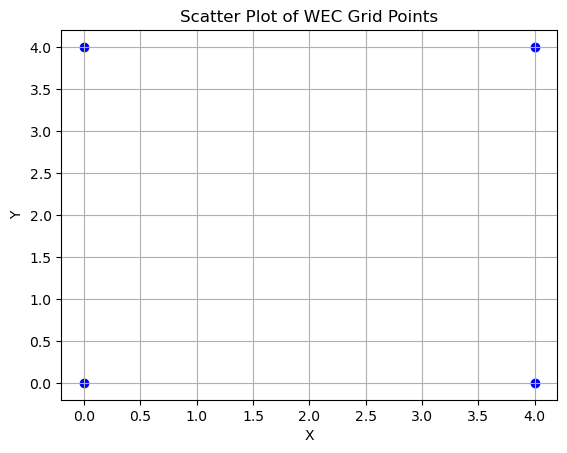

In [103]:
num_bodies = 2 #on each x, and y axis
radius = 2 #update on generate_body as well
distance = 4
grid_range = num_bodies * distance
x_coords,y_coords = np.arange(0,grid_range,distance),np.arange(0,grid_range,distance)
X, Y = np.meshgrid(x_coords, y_coords)
# Flatten the mesh grid coordinates
x_flattened = X.flatten()
y_flattened = Y.flatten()

# Plot the scatter plot
plt.scatter(x_flattened, y_flattened, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of WEC Grid Points')
plt.grid(True)
plt.show()

In [104]:
#iterate

xyzees = {(x,y,0) for x,y in zip(x_flattened,y_flattened)}
#if using more bodies from above
#xyzees = {(x,y,0) for x,y in zip(x_flattened,y_flattened)}
#print(xyzees)
    
bodies = [generate_body(xyz) for xyz in xyzees ]
body_to_loc = {body:xyz for xyz,body in zip(xyzees,bodies)}

cache_engine = BasicMatrixEngine(matrix_cache_size=1)

solver = cpt.BEMSolver(engine=cache_engine)


body_to_loc[bodies[0]][0]

4

In [105]:


def calculate_theta(X,Y,wave_direction = 0): 
    x1,y1= X[0],X[1]
    x2,y2 = Y[0], Y[1]
    
    if x1 ==x2 and y1==y2: # if samee body then should be wave direction for the diffraction
        return wave_direction
    if x2==x1:
        theta = np.pi/2
    else:
        theta = np.arctan2((y2-y1),(x2-x1))
    return theta


def get_neighbors(xyzees):
    neighbor = {xyz:[] for xyz in xyzees}
    for xyz in xyzees:
        for zyx in xyzees:
            if not xyz == zyx:
                neighbor[xyz].append(zyx)
    return neighbor


def get_unit_radiation_data(body,solver):
    '''This function gives A(w) and B(w) for given body'''
    radiationProblem = cpt.RadiationProblem(body = body, water_depth = np.infty,
                                      omega=omega) 
    solved = solver.solve(radiationProblem)
    dataset = cpt.assemble_dataset([solved])
    inertia_matrix = body.compute_rigid_body_inertia().sel(
    influenced_dof='Heave', radiating_dof='Heave'
    ).values
  
    stiffness = body.compute_hydrostatic_stiffness().sel( 
        influenced_dof='Heave', radiating_dof='Heave').values
    
   
    rad_data = {'A':dataset['added_mass'].values.flatten()[0],'B':dataset['radiation_damping'].values.flatten()[0],
                'sigma_r':solved.sources,
                'I':inertia_matrix, 'stiffness':stiffness,
                'omega':dataset['omega']}
    return rad_data

def get_unit_diffraction_data(solver,bodyj,bodyi):
    '''This function gives A(w) and B(w) for given body. 
    There is one more loop inside this function. 
    body '''
    theta_ij = calculate_theta(body_to_loc[bodyj], body_to_loc[bodyi]) 
    #F_e_i, S_i
    diffProblem = cpt.DiffractionProblem(body= bodyi, water_depth = np.infty,
                                        omega=omega, wave_direction = theta_ij ) 
    solved = solver.solve(diffProblem)
       
    diff_data = {'Fe':solved.forces['Heave'],'sigma_d':solved.sources}
       
    return diff_data # for one body combo..run for all ij in main program #for body i


# step 2
# initialize a_ij as a piecewise function with  a_ij= a0 for same body and a_ij = 0 for j!=i.
def init_pseudo_amplitude(bodyi_loc,bodyj_loc,a0 = 1):
    if bodyi_loc == bodyj_loc:
        a_ij = a0
    else:
        a_ij = 0
    return a_ij

# step 3
# Motion response
def solve_motion_response(rad_unit_data,diff_unit_data_list,a_ij,bodies):
      #get unit dataset 
     lhs = np.array([((-rad_unit_data['omega']**2)*(rad_unit_data['I'] + rad_unit_data['A'])
         - 1j*-rad_unit_data['omega']*rad_unit_data['B']
         + rad_unit_data['stiffness'])])
     rhs = np.sum([a_ij[bodyj] * diff_unit_data_list[bodyj]['Fe'] for bodyj in bodies])
     X_i = rhs/lhs
     return X_i



# Update incident waves amplitude 


def update_compute_potential(rad_unit_data, diff_unit_data,a_ij_list,X,bodyj,bodies,bodyi):
    ''' only update the amplitude from neighbors'''
    integrand_first = -1j*rad_unit_data['omega'].values * rad_unit_data['sigma_r'] * X 
  
    result = []
    for bodyk in bodies:
                if bodyk!=bodyj:
                    res = a_ij_list[bodyk] * diff_unit_data[bodyk]['sigma_d']
                    result.append(res)
    integrand_second = np.sum(np.array(result),axis = 0)
    integrand = integrand_first +  integrand_second
    integral = -1*(1/(4*np.pi)) * bodyj.mesh.surface_integral(integrand)
    #print(integral.shape) # this is a scalar representing a potential at the centre
    return integral

def check_convergence(a_ij):
    a_ij_all  = np.array([a_ij[bodyi][bodyj] for bodyi in bodies for bodyj in bodies])
    return np.all(np.abs(a_ij_all)<=0.001)





### Update here to change the number and spacing of bodies

### Algorithm by Babarit 
1) Solve radiation problem for each body - radiation only involves the body itself like the definition
2) Solve the diffraction problem of the body and its effect on other bodies when the waves diffract
3) Initialize the starting amplitude for the pseudo plane waves


In [117]:

unit_diffraction_data_list = {bodyi:{bodyj:get_unit_diffraction_data(solver,bodyj,bodyi)
                               for bodyj in bodies} for bodyi in bodies}
unit_rad_data_list = {bodyi:get_unit_radiation_data(bodyi,solver) for bodyi in bodies}


a_ij_list = {bodyi:{bodyj:init_pseudo_amplitude(body_to_loc[bodyi],body_to_loc[bodyj]) for bodyj in bodies} for bodyi in bodies}
converged = False
count = 0
while count < 2*(len(xyzees)) :
  X_i_list = {body:solve_motion_response(unit_rad_data_list[body],
                                                  unit_diffraction_data_list[body],a_ij_list[body],
                                                  bodies)
                                                    for body in bodies}

  new_phi_ij = {bodyi:{bodyj: update_compute_potential(unit_rad_data_list[bodyj],
                                                    unit_diffraction_data_list[bodyj],
                                                    a_ij_list[bodyj],
                                                    X_i_list[bodyj],
                                                    bodyj,bodies,bodyi) for bodyj in bodies} 
                                                    for bodyi in bodies }
  #including x-xj
  # e_stuff = {bodyi: {bodyj:(np.exp(1j*wave_num*(body_to_loc[bodyi][0]*np.cos(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi])) + 
  #                                                     body_to_loc[bodyi][1]*np.sin(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi]))
  #                                                       ))) for bodyj in bodies} 
  #                                                       for bodyi in bodies}

#- body_to_loc[bodyj][0]
 
  a_ij_list = {bodyi: {bodyj:new_phi_ij[bodyi][bodyj]/(np.exp(1j*wave_num*((body_to_loc[bodyj][0])*np.cos(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi])) + 
                                                     ( body_to_loc[bodyj][1])*np.sin(calculate_theta(body_to_loc[bodyj],body_to_loc[bodyi]))
                                                        ))) for bodyj in bodies} 
                                                        for bodyi in bodies}
  
  # check a_ij < 10^(-3)
  count += 1
  converged = check_convergence(a_ij_list)
  
  

 
print(f"the loop has succesfully converged? {converged}")


the loop has succesfully converged? True


In [118]:
#update pseudo incident waves amplitudes

#a_ij values are supposed to be smaller each iteration
amplitude_all = []
for bodyi,neighbor in a_ij_list.items():
    for bodyj,amplitude in neighbor.items():
        amplitude_all.append(amplitude)
#print(f"only {np.sum(np.array(amplitude_all)==1.0)} amplitude is equal 1 from {len(amplitude_all)}")
#there should be at least 4 amplitude that is 1 which is not supposed to be updated.
print(f"{np.sum(np.array(np.abs(amplitude_all))<=1e-3)} amplitude is less than 1e-3 out of  {len(amplitude_all)} total")

16 amplitude is less than 1e-3 out of  16 total


So now do we sum all the phi_ij from other body to a body and itself without interaction and use that to solve for the added mass and such?

In [ ]:
def get_total_each_body(result_dict, bodies):
    res_each_bodies = {body:[] for body in bodies}
    for bodyi,neighbor in result_dict.items():
        for bodyj,res in neighbor.items():
            res_each_bodies[bodyi].append(res)
    return res_each_bodies

phi_each_bodies = get_total_each_body(new_phi_ij,bodies)




In [120]:
diff_problems = {body:cpt.DiffractionProblem(body=body, water_depth = np.infty,
                                      omega=omega, wave_direction=0.) for body in bodies}

rad_problems = {body: cpt.RadiationProblem(body=body, water_depth = np.infty,
                                      omega=omega) for body in bodies}

diff_results = {body:solver.solve(problem) for body,problem in diff_problems.items()}
rad_results = {body:solver.solve(problem) for body,problem in rad_problems.items()}

In [121]:
body_total_phi = {body:np.sum(np.array(phi_each_bodies[body])) for body in phi_each_bodies.keys()}
# + diff_results[body].potential

In [122]:
#usual_potential = {body:diff_results[body].potential for body in bodies}


#### Solving single separately to compare the results


In [123]:
def solve(body,potential,omega):
        
        """Solve the linear potential flow problem.
        Parameters
        ----------
      diff results without interactions
        Returns
        -------
        LinearPotentialFlowResult
            an object storing the problem data and its results
        """
        rho = 1000
        new_pressure = 1j * rho * potential * omega
        #new_pressure = [new_pressure for i in  range(56)]
      
        forces = body.integrate_pressure(new_pressure)['Heave']
        return forces
# + solver.solve(diff_problems[body]).forces['Heave'] 
total_result = {body:solve(body,phi,omega)for body,phi in body_total_phi.items()}
total_result
    

{FloatingBody(mesh=cylinder_174, dofs={Surge, Sway, Heave, Roll, Pitch, Yaw}, name=4_4_0): (-2.321192384350799e-22-5.669313056683448e-24j),
 FloatingBody(mesh=cylinder_180, dofs={Surge, Sway, Heave, Roll, Pitch, Yaw}, name=0_0_0): (-2.3211923843507993e-22-5.669313056683449e-24j),
 FloatingBody(mesh=cylinder_186, dofs={Surge, Sway, Heave, Roll, Pitch, Yaw}, name=0_4_0): (-2.3211923843507993e-22-5.669313056683449e-24j),
 FloatingBody(mesh=cylinder_192, dofs={Surge, Sway, Heave, Roll, Pitch, Yaw}, name=4_0_0): (-2.321192384350799e-22-5.669313056683449e-24j)}

### Solving combined (by joining) to compare the results 

In [124]:
# Combine the two individual bodies into a single body.
all_bodies =  bodies[0].join_bodies(*bodies[1:])
all_bodies.keep_immersed_part()

# The merged body can be used to define the problems in the usual way
#problems = [cpt.RadiationProblem(body=all_bodies, radiating_dof=dof, omega=1.0) for dof in all_bodies.dofs]
problems = cpt.DiffractionProblem(body=all_bodies, wave_direction=0.0, omega=omega)

# Solves the problem
solver = cpt.BEMSolver()
results_all_bodies = solver.solve(problems)

print(results_all_bodies.forces)

{'4_4_0__Surge': (-22.94429709841562-57.244163294930104j), '4_4_0__Sway': (-23.280979039684514+6.858035331673889j), '4_4_0__Heave': (-272.3149762286837+21.345557185227896j), '4_4_0__Roll': (3.8284992954197454+0.10526999287234062j), '4_4_0__Pitch': (-3.8721606195618845+8.450295468567674j), '4_4_0__Yaw': (-3.77860565002609e-14+1.0375055632217947e-14j), '0_0_0__Surge': (23.17752609856291-57.15104272434692j), '0_0_0__Sway': (23.252823707162715+6.951995820953709j), '0_0_0__Heave': (-272.2167660134676-26.821404016639697j), '0_0_0__Roll': (-3.828897014049049+0.08980874315519394j), '0_0_0__Pitch': (3.8376741457071653+8.465863626599685j), '0_0_0__Yaw': (9.152774556569857e-16+1.2130916622149387e-14j), '0_4_0__Surge': (23.1775260985629-57.151042724346965j), '0_4_0__Sway': (-23.2528237071627-6.951995820953709j), '0_4_0__Heave': (-272.2167660134676-26.82140401663972j), '0_4_0__Roll': (3.828897014049584-0.08980874315514953j), '0_4_0__Pitch': (3.83767414570711+8.465863626599713j), '0_4_0__Yaw': (2.40

In [125]:
results_all_bodies.forces['0_0_0__Heave'] 

(-272.2167660134676-26.821404016639697j)

In [126]:
diff_results[bodies[0]].forces['Heave']

(-154.0006496668115-1.174054132335016j)

In [127]:
results_all_bodies.forces['0_0_0__Heave']  - diff_results[bodies[0]].forces['Heave']

(-118.21611634665607-25.64734988430468j)